# Notebook for FFPE Paper Figures

### Imports

In [1]:
%matplotlib inline
import seaborn as sns
from glob import glob
import os
from os.path import join
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.patches as patches
from matplotlib_venn import venn3,venn3_unweighted,venn2
from matplotlib.patches import Patch
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from statannot import add_stat_annotation
from sklearn.metrics import r2_score
import pandas as pd
from io import BytesIO
from io import StringIO
import numpy as np
import math
from IPython.core.display import SVG

### Helper Functions

In [2]:
import met_brewer
colors = met_brewer.met_brew(name="Monet", n=12, brew_type="continuous")

In [3]:
from IPython.display import HTML
for color in colors:
    colored_background = f'<div style="background-color:{color}; padding:10px;"></div>'
    display(HTML(f"{colored_background}"))
    print(color)

#4e6d58


#6a917c


#8db3a1


#b5ccc1


#decacd


#cfabb2


#b68990


#966b72


#525579


#626e99


#9099bf


#c2cae3


In [4]:
monet_palette = met_brewer.met_brew(name="Monet", n=12, brew_type="continuous")
pal = {
    "FFPE":monet_palette[2],
    "Frozen":monet_palette[-3],
}
morgenstern_palette = met_brewer.met_brew(name="Morgenstern", n=6, brew_type="continuous")
inst_pal = {
    "MSK":morgenstern_palette[1],
    "BCC":morgenstern_palette[3],
    "OXF":morgenstern_palette[5],
}
inst_to_center = {
    "MSK":"C1",
    "BCC":"C2",
    "OXF":"C3",
}
center_pal = {
    c:inst_pal[center] for center, c in inst_to_center.items()
}

In [5]:
def display_svg(filename=None, font="Arial"):
    plt.rcParams["svg.fonttype"] = "none"
    svg = BytesIO()
    plt.tight_layout()
    plt.savefig(svg, format="svg", bbox_inches="tight")
    if filename:
        plt.savefig(filename, format="svg", bbox_inches="tight")
    plt.close()
    svg.seek(0)
    display(
        SVG(
            svg.read()
            .decode("utf-8")
            .replace("font-family:DejaVu Sans", f"font-family:{font}")
        )
    )

In [6]:
def set_all_font_sizes(ax, font_size=12):
    # Set title font size
    ax.title.set_fontsize(font_size)
    
    # Set axis label font sizes
    ax.xaxis.label.set_fontsize(font_size)
    ax.yaxis.label.set_fontsize(font_size)
    
    # Set tick label font sizes
    ax.tick_params(axis='both', which='major', labelsize=font_size)
    
    # Set legend font size if a legend exists
    if ax.legend_:
        for text in ax.legend_.get_texts():
            text.set_fontsize(font_size)

def format_plot(ax):
    set_all_font_sizes(ax, 12)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    sns.despine()

In [7]:
def calculate_fold_change(x, y, log=False):
    if x == 0 or y == 0:
        if log:
            return -np.inf
        return np.nan
    
    fc = y/x

    if log:
        fc = np.log2(fc)
    
    return fc

In [8]:
msk_pairs = {
    "H134753": ("I-H-134753-T1-1-D1-1", "IID_H200663_T01_01_WG01"),
    "H135022": ("I-H-135022-T1-2-D1-1", "IID_H200664_T01_01_WG01"),
    "H135387": ("I-H-135387-T1-1-D1-1", "IID_H200665_T01_01_WG01"),
    "H156407": ("IID_H156407_T01_01_WG01", "IID_H200667_T01_01_WG01"),
    "H158273": ("IID_H158273_T01_01_WG01", "IID_H200669_T01_01_WG01"),
    "H158878": ("IID_H158878_T01_01_WG01", "IID_H200670_T01_01_WG01"),
    "H158880": ("IID_H158880_T01_01_WG01", "IID_H200671_T01_01_WG01"),
    "H158918": ("IID_H158918_T01_01_WG01", "IID_H200672_T01_01_WG01"),
    "H159369": ("IID_H159369_T01_01_WG01", "IID_H200673_T01_01_WG01"),
    "H135462": ("IID_H135462_T02_01_WG01", "IID_H200674_T01_01_WG01")
}
bcc_pairs = {
    "H201536": ("IID_H201536_T02_01_WG01", "IID_H201536_T01_01_WG01"),
    "H201537": ("IID_H201537_T01_01_WG01", "IID_H201537_T02_01_WG01"),
    "H201538": ("IID_H201538_T01_01_WG01", "IID_H201538_T02_01_WG01"),
    "H201539": ("IID_H201539_T01_01_WG01", "IID_H201539_T02_01_WG01"),
    "H201540": ("IID_H201540_T01_01_WG01", "IID_H201540_T02_01_WG01"),
    "H201542": ("IID_H201542_T01_01_WG01", "IID_H201542_T02_01_WG01"),
}
oxf_pairs = {
    "H203495": ("IID_H203495_T01_01_WG01", "IID_H203495_T02_01_WG01"),
    "H203498": ("IID_H203498_T01_01_WG01", "IID_H203498_T02_01_WG01"),
    "H203499": ("IID_H203499_T01_01_WG01", "IID_H203499_T02_01_WG01"),
    "H203500": ("IID_H203500_T01_01_WG01", "IID_H203500_T02_01_WG01"),
    "H203501": ("IID_H203501_T01_01_WG01", "IID_H203501_T02_01_WG01"),
    "H203502": ("IID_H203502_T01_01_WG01", "IID_H203502_T02_01_WG01"),
    "H203503": ("IID_H203503_T01_01_WG01", "IID_H203503_T02_01_WG01"),
    "H203504": ("IID_H203504_T01_01_WG01", "IID_H203504_T02_01_WG01"),
    "H203505": ("IID_H203505_T01_01_WG01", "IID_H203505_T02_01_WG01"),
    "H203506": ("IID_H203506_T01_01_WG01", "IID_H203506_T02_01_WG01"),
    "H203507": ("IID_H203507_T01_01_WG01", "IID_H203507_T03_01_WG01"),
    "H203508": ("IID_H203508_T01_01_WG01", "IID_H203508_T03_01_WG01"),
    "H203511": ("IID_H203511_T01_01_WG01", "IID_H203511_T02_01_WG01"),
    "H203512": ("IID_H203512_T01_01_WG01", "IID_H203512_T02_01_WG01"),
    "H203513": ("IID_H203513_T01_01_WG01", "IID_H203513_T02_01_WG01"),
    "H203514": ("IID_H203514_T01_01_WG01", "IID_H203514_T02_01_WG01"),
    "H203515": ("IID_H203515_T01_01_WG01", "IID_H203515_T02_01_WG01"),
    "H203516": ("IID_H203516_T01_01_WG01", "IID_H203516_T02_01_WG01"),
    "H203517": ("IID_H203517_T01_01_WG01", "IID_H203517_T02_01_WG01"),
    "H203518": ("IID_H203518_T01_01_WG01", "IID_H203518_T02_01_WG01"),
    "H203519": ("IID_H203519_T01_01_WG01", "IID_H203519_T02_01_WG01"),
    "H203520": ("IID_H203520_T01_01_WG01", "IID_H203520_T02_01_WG01"),
    "H203522": ("IID_H203522_T01_01_WG01", "IID_H203522_T02_01_WG01"),
    "H203523": ("IID_H203523_T01_01_WG01", "IID_H203523_T02_01_WG01"),
    "H203524": ("IID_H203524_T01_01_WG01", "IID_H203524_T02_01_WG01"),
    "H203525": ("IID_H203525_T01_01_WG01", "IID_H203525_T02_01_WG01"),
    "H203526": ("IID_H203526_T01_01_WG01", "IID_H203526_T02_01_WG01"),
    "H203527": ("IID_H203527_T01_01_WG01", "IID_H203527_T02_01_WG01"),
    "H203530": ("IID_H203530_T01_01_WG01", "IID_H203530_T02_01_WG01"),
    "H203531": ("IID_H203531_T01_01_WG01", "IID_H203531_T02_01_WG01"),
    "H203532": ("IID_H203532_T01_01_WG01", "IID_H203532_T02_01_WG01"),
    "H203533": ("IID_H203533_T01_01_WG01", "IID_H203533_T02_01_WG01"),
    "H203534": ("IID_H203534_T01_01_WG01", "IID_H203534_T02_01_WG01"),
    "H203535": ("IID_H203535_T01_01_WG01", "IID_H203535_T02_01_WG01"),
    "H203537": ("IID_H203537_T01_01_WG01", "IID_H203537_T02_01_WG01"),
    "H203539": ("IID_H203539_T01_01_WG01", "IID_H203539_T02_01_WG01"),
    "H203540": ("IID_H203540_T01_01_WG01", "IID_H203540_T02_01_WG01"),
    "H203541": ("IID_H203541_T01_01_WG01", "IID_H203541_T02_01_WG01"),
    "H203542": ("IID_H203542_T01_01_WG01", "IID_H203542_T02_01_WG01"),
    "H203544": ("IID_H203544_T01_01_WG01", "IID_H203544_T02_01_WG01")
}
all_pairs = {**msk_pairs, **bcc_pairs, **oxf_pairs}

msk_samples = []
for p in msk_pairs.values():
    msk_samples.append(p[0])
    msk_samples.append(p[1])
bcc_samples = []
for p in bcc_pairs.values():
    bcc_samples.append(p[0])
    bcc_samples.append(p[1])
oxf_samples = []
for p in oxf_pairs.values():
    oxf_samples.append(p[0])
    oxf_samples.append(p[1])

def get_institution(iid):
    if iid in msk_pairs or iid in msk_samples:
        return "MSK"
    elif iid in bcc_pairs or iid in bcc_samples:
        return "BCC"
    elif iid in oxf_pairs or iid in oxf_samples:
        return "OXF"

In [9]:
st1  = pd.read_excel("../data/Domenico_et_al_2025_Tables.xlsx", sheet_name="Supplementary Table 1",  skiprows=1)#, engine='openpyxl',)
st2  = pd.read_excel("../data/Domenico_et_al_2025_Tables.xlsx", sheet_name="Supplementary Table 2",  skiprows=1)#, engine='openpyxl',)
st3  = pd.read_excel("../data/Domenico_et_al_2025_Tables.xlsx", sheet_name="Supplementary Table 3",  skiprows=1)#, engine='openpyxl',)
st4  = pd.read_excel("../data/Domenico_et_al_2025_Tables.xlsx", sheet_name="Supplementary Table 4",  skiprows=1)#, engine='openpyxl',)
st5  = pd.read_excel("../data/Domenico_et_al_2025_Tables.xlsx", sheet_name="Supplementary Table 5",  skiprows=1)#, engine='openpyxl',)
st6  = pd.read_excel("../data/Domenico_et_al_2025_Tables.xlsx", sheet_name="Supplementary Table 6",  skiprows=1)#, engine='openpyxl',)
st7  = pd.read_excel("../data/Domenico_et_al_2025_Tables.xlsx", sheet_name="Supplementary Table 7",  skiprows=1)#, engine='openpyxl',)
st8  = pd.read_excel("../data/Domenico_et_al_2025_Tables.xlsx", sheet_name="Supplementary Table 8",  skiprows=1)#, engine='openpyxl',)
st9  = pd.read_excel("../data/Domenico_et_al_2025_Tables.xlsx", sheet_name="Supplementary Table 9",  skiprows=1)#, engine='openpyxl',)
st12 = pd.read_excel("../data/Domenico_et_al_2025_Tables.xlsx", sheet_name="Supplementary Table 12", skiprows=1)#, engine='openpyxl',)
st13 = pd.read_excel("../data/Domenico_et_al_2025_Tables.xlsx", sheet_name="Supplementary Table 13", skiprows=1)#, engine='openpyxl',)
st14 = pd.read_excel("../data/Domenico_et_al_2025_Tables.xlsx", sheet_name="Supplementary Table 14", skiprows=1)#, engine='openpyxl',)
st15 = pd.read_excel("../data/Domenico_et_al_2025_Tables.xlsx", sheet_name="Supplementary Table 15", skiprows=1)#, engine='openpyxl',)
st16 = pd.read_excel("../data/Domenico_et_al_2025_Tables.xlsx", sheet_name="Supplementary Table 16", skiprows=1)#, engine='openpyxl',)
st17 = pd.read_excel("../data/Domenico_et_al_2025_Tables.xlsx", sheet_name="Supplementary Table 17", skiprows=1)#, engine='openpyxl',)

In [10]:
fig1__all_mutation_totals = pd.read_csv("../data/fig1__all_mutation_totals.tsv", sep="\t")
fig1__consensus_mutation_totals = pd.read_csv("../data/fig1__consensus_mutation_totals.tsv", sep="\t")

In [11]:
purity_order = {}
for hid, (_, ffpe) in all_pairs.items():
    purity_order[hid] = st1.set_index("Individual ID").loc[hid]["FFPE Purity"]
purity_order = [k for k, v in sorted(purity_order.items(), key=lambda item: item[1])]

In [12]:
sns.set_style("white")

## Figure 1

In [13]:
comparator_df = pd.DataFrame(columns=[
    "Individual ID", "Mutation Type",
    "FFPE Only All Calls", "FFPE Only Consensus Calls",
    "All Calls Percent Artifacts", "Consensus Calls Percent Artifacts"
])
all_calls_plot = fig1__all_mutation_totals.copy()
consensus_calls_plot = fig1__consensus_mutation_totals.copy()
for group in ["SNVs", "Indels", "SVs"]:
    for iid in purity_order:
        comparator_df = comparator_df.append(
            {
                "Individual ID": iid,
                "Mutation Type": group,
                "FFPE Only All Calls": all_calls_plot[
                    (all_calls_plot["Individual ID"]==iid)&(all_calls_plot["Mutation Type"]==group)
                ].iloc[0]["FFPE Only Count"],
                "FFPE Only Consensus Calls": consensus_calls_plot[
                    (consensus_calls_plot["Individual ID"]==iid)&(consensus_calls_plot["Mutation Type"]==group)
                ].iloc[0]["FFPE Only Count"],
                "All Calls Percent Artifacts": all_calls_plot[
                    (all_calls_plot["Individual ID"]==iid)&(all_calls_plot["Mutation Type"]==group)
                ].iloc[0]["FFPE Only"],
                "Consensus Calls Percent Artifacts": consensus_calls_plot[
                    (consensus_calls_plot["Individual ID"]==iid)&(consensus_calls_plot["Mutation Type"]==group)
                ].iloc[0]["FFPE Only"],
            },
            ignore_index=True
        )

#### 1b.

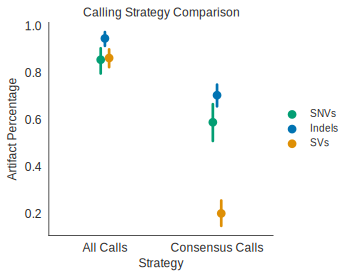

In [14]:
fig, ax = plt.subplots(figsize=(5,4))
comparator_df_point = pd.melt(
    comparator_df,
    id_vars=["Individual ID", "Mutation Type"],
    value_vars=["All Calls Percent Artifacts", "Consensus Calls Percent Artifacts"],
)
g = sns.pointplot(
    data=comparator_df_point, y="value", x="variable", hue="Mutation Type",
    palette=dict(zip(["Indels","SVs","SNVs"],sns.color_palette("colorblind"))),
    dodge=True,
    join=False,
)

g.set_xticklabels([l.get_text().replace(" Percent Artifacts", "") for l in g.get_xticklabels()])

g.set_title("Calling Strategy Comparison")
g.set_ylabel("Artifact Percentage")
g.set_xlabel("Strategy")

format_plot(g)
display_svg()

#### 1c.

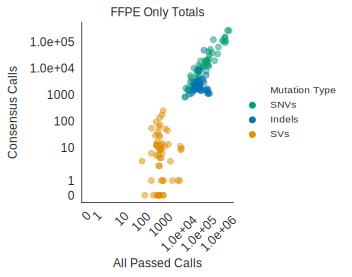

In [15]:
from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(figsize=(5,4))
g=sns.scatterplot(
    data=comparator_df, x="FFPE Only All Calls", y="FFPE Only Consensus Calls", hue="Mutation Type", edgecolor=None, alpha=0.5,
    palette=dict(zip(["Indels","SVs","SNVs"],sns.color_palette("colorblind"))))#met_brewer.met_brew(name="Juarez", n=3, brew_type="continuous"))))
g.set_xscale("symlog")
g.set_yscale("symlog")

# Define function to format ticks as numbers
g.set_ylim(-.5,)
g.set_xlim(-.5,)
plt.xticks(rotation=45)
def formatter_func(x, pos):
    if abs(x) <= 1000:
        return '{:.0f}'.format(x)
    else:
        return '{:.1e}'.format(x)#.replace('e+0', 'e')

# Apply the formatter to x and y axis
g.xaxis.set_major_formatter(FuncFormatter(formatter_func))
g.yaxis.set_major_formatter(FuncFormatter(formatter_func))
g.set_title("FFPE Only Totals")
g.set_ylabel("Consensus Calls")
g.set_xlabel("All Passed Calls")

format_plot(g)
display_svg()

#### 1d.

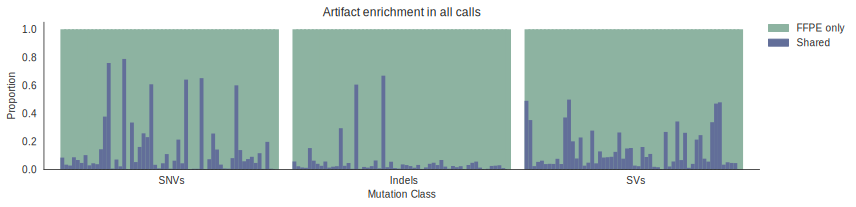

In [16]:
fig, ax = plt.subplots(figsize=(12,3))

all_calls_plot = fig1__all_mutation_totals.copy()
i=0
for group in ["SNVs", "Indels", "SVs"]:
    samples = all_calls_plot[all_calls_plot["Mutation Type"]==group].copy()
    samples["Individual ID"] = pd.Categorical(samples["Individual ID"], categories=purity_order, ordered=True)
    for _, s in samples.sort_values(by="Individual ID").iterrows():
        ax.bar(i, 1, color = pal["FFPE"], width=1.5, lw=0)
        ax.bar(i, s["Shared"], color = pal["Frozen"], width=1.5, lw=0)
        i+=1
    i+=4
ax.set_xlim(-5,180)
ax.set_xticks([56/2, 56/2+60, 56/2+60+60])
ax.set_xticklabels(["SNVs", "Indels", "SVs"])
sns.despine()

ax.set_xlabel("Mutation Class")
ax.set_ylabel("Proportion")
ax.set_title("Artifact enrichment in all calls")

# Create the legend with the custom patches
labelmap = {"FFPE":"FFPE only", "Frozen":"Shared"}
legend = ax.legend(
    handles=[mpatches.Patch(color=c, label=labelmap[l]) for l,c in pal.items()],
    loc='upper left',
    bbox_to_anchor=(1,1.05),
    frameon=False)

display_svg()

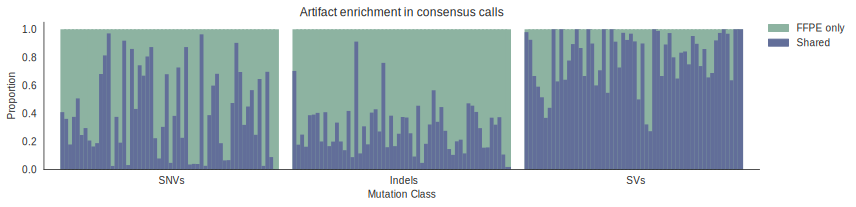

In [17]:
fig, ax = plt.subplots(figsize=(12,3))

consensus_calls_plot = fig1__consensus_mutation_totals.copy()
i=0
for group in ["SNVs", "Indels", "SVs"]:
    samples = consensus_calls_plot[consensus_calls_plot["Mutation Type"]==group].copy()
    samples["Individual ID"] = pd.Categorical(samples["Individual ID"], categories=purity_order, ordered=True)
    for _, s in samples.sort_values(by="Individual ID").iterrows():
        ax.bar(i, 1, color = pal["FFPE"], width=1.5, lw=0)
        ax.bar(i, s["Shared"], color = pal["Frozen"], width=1.5, lw=0)
        i+=1
    i+=4
ax.set_xlim(-5,180)
ax.set_xticks([56/2, 56/2+60, 56/2+60+60])
ax.set_xticklabels(["SNVs", "Indels", "SVs"])
sns.despine()

ax.set_xlabel("Mutation Class")
ax.set_ylabel("Proportion")
ax.set_title("Artifact enrichment in consensus calls")

# Create the legend with the custom patches
labelmap = {"FFPE":"FFPE only", "Frozen":"Shared"}
legend = ax.legend(
    handles=[mpatches.Patch(color=c, label=labelmap[l]) for l,c in pal.items()],
    loc='upper left',
    bbox_to_anchor=(1,1.05),
    frameon=False)

display_svg()

## Figure 2

#### 2c.

In [18]:
tmb_df = pd.DataFrame()
for _, row in st2.iterrows():
    tmb_df = tmb_df.append(
        {
            "HID": row["Individual ID"],
            "Sample Type": row["Tissue Source"],
            "TMB": (row["Number of Coding SNVs"]+row["Number of Coding Indels"])/30,
            "TMB Type": "Coding",
        },
        ignore_index=True
    )
    tmb_df = tmb_df.append(
        {
            "HID": row["Individual ID"],
            "Sample Type": row["Tissue Source"],
            "TMB": (row["Number of SNVs"]+row["Number of Indels"])/2900,
            "TMB Type": "Genomewide",
        },
        ignore_index=True
    )

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Frozen_Coding v.s. FFPE_Coding: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.489e-01 U_stat=1.236e+03
Frozen_Genomewide v.s. FFPE_Genomewide: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.381e-06 U_stat=6.670e+02


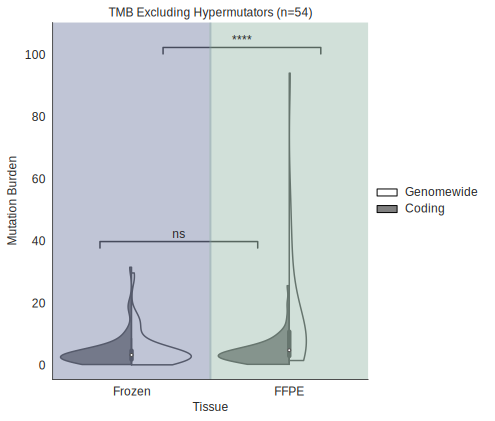

In [19]:
x = "Sample Type"
y = "TMB"
hue = "TMB Type"
hue_order=["Coding","Genomewide"]
box_pairs=[
    (("Frozen", "Coding"), ("FFPE", "Coding")),
    (("Frozen", "Genomewide"), ("FFPE", "Genomewide")),
]
from statannot import add_stat_annotation
fig, ax = plt.subplots(figsize=[7,6])
sns.set_color_codes('muted')

exclude = ["H203508", "H203526"]

g = sns.violinplot(data=tmb_df[~tmb_df.HID.isin(exclude)], x='Sample Type', y='TMB', hue='TMB Type', split=True, palette={"Genomewide":"w","Coding":"gray"},
                   ax=ax, zorder=1, cut=0, width=.9)

add_stat_annotation(ax, data=tmb_df[~tmb_df.HID.isin(exclude)], x=x, y=y, hue=hue, box_pairs=box_pairs,
                    test='Mann-Whitney', loc='inside', verbose=2, fontsize=12)

ax.set_xlim(-.5,1.5)
ax.axvline('Frozen', color=pal["Frozen"],linewidth=160,alpha=0.4)
ax.axvline('FFPE', color=pal["FFPE"],linewidth=160,alpha=0.4)

ax.set_xlabel('Tissue')
ax.set_ylabel('Mutation Burden')
ax.set_title(f"TMB Excluding Hypermutators (n={int(len(tmb_df[~tmb_df.HID.isin(exclude)])/4)})")

handles = [Patch(facecolor='w', edgecolor='black', label='Genomewide'),
           Patch(facecolor='gray', edgecolor='black', label='Coding')]
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1,.5),frameon=False)

sns.despine()
set_all_font_sizes(ax, font_size=12)
display_svg()

#### 2d.

In [20]:
from scipy import spatial
contributions = st6.copy().set_index("Individual ID")
contributions = contributions[[c for c in contributions.columns if "Tissue Type" in c or "SBS" in c]]
contr_cosines = pd.DataFrame()
for iid in all_pairs.keys():
    ff_ffpe_cos = 1 - spatial.distance.cosine(
        contributions[contributions["Tissue Type"]=="FF"].loc[iid].drop("Tissue Type"),
        contributions[contributions["Tissue Type"]=="FFPE"].loc[iid].drop("Tissue Type"))
    contr_cosines = contr_cosines.append({"HID":iid, "COSINE_SIMILARITY":ff_ffpe_cos}, ignore_index=True)
    
contr_cosines["Institution"] = contr_cosines.apply(lambda x: get_institution(x.HID), axis=1)
snv_contr_cosines = contr_cosines.copy()
snv_contr_cosines["Mutation Type"] = "SBS Contributions"

In [21]:
from scipy import spatial
contributions = st6.copy().set_index("Individual ID")
contributions = contributions[[c for c in contributions.columns if "Tissue Type" in c or "ID" in c]]
contr_cosines = pd.DataFrame()
for iid in all_pairs.keys():
    ff_ffpe_cos = 1 - spatial.distance.cosine(
        contributions[contributions["Tissue Type"]=="FF"].loc[iid].drop("Tissue Type"),
        contributions[contributions["Tissue Type"]=="FFPE"].loc[iid].drop("Tissue Type"))
    contr_cosines = contr_cosines.append({"HID":iid, "COSINE_SIMILARITY":ff_ffpe_cos}, ignore_index=True)
    
contr_cosines["Institution"] = contr_cosines.apply(lambda x: get_institution(x.HID), axis=1)
indel_contr_cosines = contr_cosines.copy()
indel_contr_cosines["Mutation Type"] = "ID Contributions"

In [22]:
from scipy import spatial
contexts = st7.copy().set_index("Individual ID")
contx_cosines = pd.DataFrame()
for iid in all_pairs.keys():
    ff_ffpe_cos = 1 - spatial.distance.cosine(
        list(contexts[contexts["Tissue Type"]=="FF"].loc[iid].drop("Tissue Type")),
        list(contexts[contexts["Tissue Type"]=="FFPE"].loc[iid].drop("Tissue Type")))
    if np.isnan(ff_ffpe_cos):
        ff_ffpe_cos = 1
    contx_cosines = contx_cosines.append(
        {
            "HID":iid,
            "COSINE_SIMILARITY":ff_ffpe_cos,
            "COVERAGE_DIFFERENCE":(
                st1.set_index("Individual ID").loc[iid]["Fresh Frozen Median Coverage"] -
                st1.set_index("Individual ID").loc[iid]["FFPE Median Coverage"]
            )
        }, ignore_index=True)
    
contx_cosines["Institution"] = contx_cosines.apply(lambda x: get_institution(x.HID), axis=1)
sv_contx_cosines = contx_cosines.copy()
sv_contx_cosines["Mutation Type"] = "SV Contexts"

/usersoftware/papaemme/isabl/opt/python/.envs/users/domenicd/ffpe_figures/lib/python3.6/site-packages/scipy/spatial/distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [23]:
merged_cosines = snv_contr_cosines.append(indel_contr_cosines.append(sv_contx_cosines.drop(columns=["COVERAGE_DIFFERENCE"]),ignore_index=True), ignore_index=True)

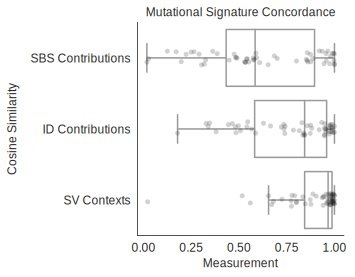

In [24]:
fig, ax = plt.subplots(figsize=(5,4))
sns.boxplot(data=merged_cosines, y="Mutation Type", x="COSINE_SIMILARITY", ax=ax, showfliers=False, palette=["w"]*3, color="k")
sns.stripplot(data=merged_cosines, y="Mutation Type", x="COSINE_SIMILARITY", color="k",
              ax=ax, alpha=0.2, jitter=True, dodge=True)
ax.set_ylabel("Cosine Similarity")
ax.set_xlabel("Measurement")
ax.set_title("Mutational Signature Concordance")
set_all_font_sizes(ax, font_size=12)
sns.despine()
display_svg()

#### 2e.

In [25]:
contributions = st6.copy().set_index("Individual ID")
sbs_cntr = contributions[[c for c in contributions.columns if "Tissue Type" in c or "ID" in c]]
id_cntr = contributions[[c for c in contributions.columns if "Tissue Type" in c or "ID" in c]]

In [26]:
from scipy.stats import ranksums

sig_sigs = pd.DataFrame(columns=["HID", "Tissue Type", "Signature", "Value"])

for c in contributions.columns:
    output = ""
    if c == "Tissue Type":
        continue
    ff_contr = contributions[(contributions["Tissue Type"]=="FF")][c].to_list()
    ffpe_contr = contributions[(contributions["Tissue Type"]=="FFPE")][c].to_list()
    stat, p_value = ranksums(ff_contr, ffpe_contr)
    
    if np.median(ff_contr) > 0.05 or np.median(ffpe_contr) > 0.05:
        alpha = 0.05
        if p_value < alpha:
            print(c, "---------------------------------------------------")
            print(f'Statistic: {stat}, p-value: {p_value}', end=", Status: ")
            if np.median(ff_contr) < np.median(ffpe_contr):
                print("Higher: FFPE")
            else:
                print("Higher: Frozen")
            
            for iid, v in contributions[(contributions["Tissue Type"]=="FF")][c].items():
                sig_sigs = sig_sigs.append(
                    {
                        "HID":iid,
                        "Tissue Type":"Frozen",
                        "Signature":c,
                        "Value":v
                    }, ignore_index=True
                )
            for iid, v in contributions[(contributions["Tissue Type"]=="FFPE")][c].items():
                sig_sigs = sig_sigs.append(
                    {
                        "HID":iid,
                        "Tissue Type":"FFPE",
                        "Signature":c,
                        "Value":v
                    }, ignore_index=True
                )

SBS1 ---------------------------------------------------
Statistic: 2.5080757230195854, p-value: 0.012139065018021093, Status: Higher: Frozen
SBS37 ---------------------------------------------------
Statistic: -6.814284621011449, p-value: 9.47339844641414e-12, Status: Higher: FFPE
ID2 ---------------------------------------------------
Statistic: -2.991069423740295, p-value: 0.002780022832541442, Status: Higher: FFPE


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SBS37_Frozen v.s. SBS37_FFPE: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.211e-12 U_stat=3.970e+02
SBS1_Frozen v.s. SBS1_FFPE: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.641e-02 U_stat=1.999e+03
ID2_Frozen v.s. ID2_FFPE: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.420e-03 U_stat=1.054e+03


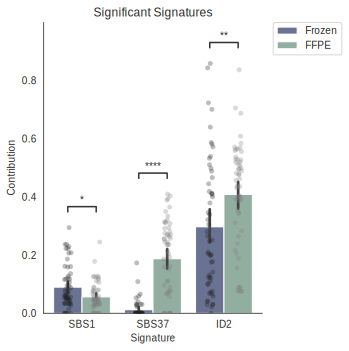

In [27]:
fig, ax = plt.subplots(figsize=(5,5))
sns.barplot(data=sig_sigs, x="Signature", y="Value", hue="Tissue Type", palette=pal)
sns.stripplot(data=sig_sigs, x="Signature", y="Value", hue="Tissue Type", dodge=True, jitter=1, color="gray", alpha=0.3)


x = "Signature"
y = "Value"
hue = "Tissue Type"
box_pairs=[
    ((sig, "Frozen"), (sig, "FFPE"))
    for sig in sig_sigs.Signature.unique()
    ]

add_stat_annotation(ax, data=sig_sigs, x=x, y=y, hue=hue, box_pairs=box_pairs,
    test='Mann-Whitney', loc='inside', verbose=2)

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[2::], labels[2::], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
ax.set_title("Significant Signatures")
ax.set_ylabel("Contribution")
display_svg()

#### 2f.

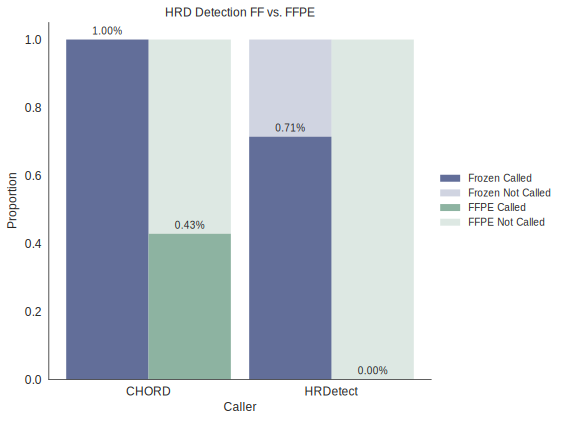

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data
data = {
    'Caller': (['HRDetect']*7*2)+(['CHORD']*7*2),
    'Status': (['Called']*5)+(["Not Called"]*2)+(["Not Called"]*7)+(["Called"]*7)+(["Called"]*3)+(["Not Called"]*4),
    'Tissue Type': (['Frozen']*7)+(['FFPE']*7)+(['Frozen']*7)+(['FFPE']*7),
}

# Create a DataFrame
df = pd.DataFrame(data)

# Calculate the proportion of called vs not called for each caller and chemistry
df_counts = df.groupby(['Caller', 'Tissue Type', 'Status']).size().unstack(fill_value=0)
df_counts['Total'] = df_counts.sum(axis=1)
df_counts['Called'] = df_counts['Called'] / df_counts['Total']
df_counts['Not Called'] = df_counts['Not Called'] / df_counts['Total']
df_counts = df_counts.drop(columns='Total').reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.45

# Define the positions of the bars
callers = df_counts['Caller'].unique()
tissue_types = df_counts['Tissue Type'].unique()
positions = range(len(callers))

for i, tissue_type in enumerate(reversed(tissue_types)):
    # Filter data for each chemistry
    subset = df_counts[df_counts['Tissue Type'] == tissue_type]
    # Plot the bars for "Called"
    bars_called = ax.bar(
        [p + bar_width * i for p in positions], subset['Called'],
        width=bar_width,
        label=f'{tissue_type} Called',
        color=pal[tissue_type],
        linewidth=0,
    )
    # Plot the bars for "Not Called" on top
    bars_not_called = ax.bar(
        [p + bar_width * i for p in positions],
        subset['Not Called'], bottom=subset['Called'],
        width=bar_width,
        label=f'{tissue_type} Not Called',
        color=pal[tissue_type], alpha=0.3,
        linewidth=0,
    )
    
    for bar in bars_called:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Customize the plot
ax.set_xlabel('Caller')
ax.set_ylabel('Proportion')
ax.set_title('HRD Detection FF vs. FFPE')
ax.set_xticks([p + bar_width * (2 - 1) / 2 for p in positions])
ax.set_xticklabels(callers)
ax.set_ylim(0, 1.05)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

sns.despine()
plt.tight_layout()
format_plot(ax)
display_svg()

#### 2g.

/usersoftware/papaemme/isabl/opt/python/.envs/users/domenicd/ffpe_figures/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  after removing the cwd from sys.path.


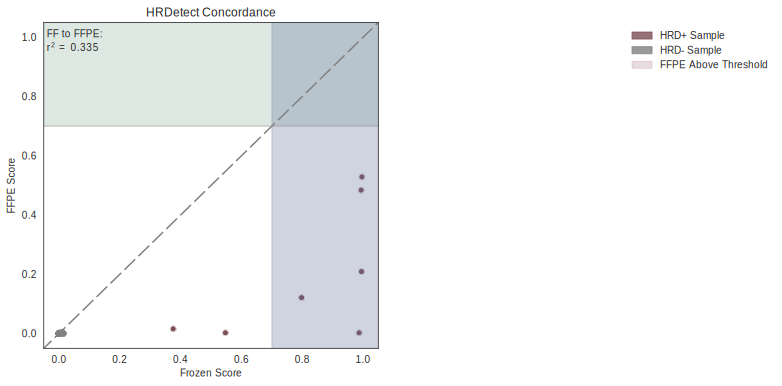

In [29]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(
    data=st8,
    x="Fresh Frozen HRDetect",
    y="FFPE HRDetect",
    ax=ax,
    color="gray",
    edgecolor=None,
)
sns.scatterplot(
    data=st8[(st8["Fresh Frozen HRDetect"]>.7)|(st8["Fresh Frozen CHORD"]>.5)],
    x="Fresh Frozen HRDetect",
    y="FFPE HRDetect",
    ax=ax,
    color="#7E4E55",
)

# ax.fill_between([-0.05,2],0.7,1.5, color='#b68990', alpha=0.3)
# ax.fill_between([-0.05,2],-1,0.7, color='w', alpha=0.2)

# ax.fill_between([-0.05, 2],0.7,1.5, color='#b68990', alpha=0.3)
# ax.fill_betweenx([-0.05, 2], 0.7, 1.5, color='#b68990', alpha=0.3)
ax.fill_between([-0.05, 2],0.7,1.5, color=pal["FFPE"], alpha=0.3)
ax.fill_betweenx([-0.05, 2], 0.7, 1.5, color=pal["Frozen"], alpha=0.3)

sns.lineplot(
    x=[-1,2],
    y=[-1,2],
    ax=ax,
    color="gray",
)

# Extract the red and black point datasets
points = {}
for iid, row in st8[(st8["Fresh Frozen HRDetect"] > .7) | (st8["Fresh Frozen CHORD"] > .5)].set_index("Individual ID").iterrows():
    points[iid] = (
        row[["Fresh Frozen HRDetect", "FFPE HRDetect"]].values,
        row[["Fresh Frozen HRDetect", "Filtered FFPE HRDetect"]].values,
    )

ax.axhline(.7, alpha=0.3, color="#b68990")
ax.lines[0].set_linestyle((5, (10, 3)))
ax.set_ylim(-0.05,1.05)
ax.set_xlim(-0.05,1.05)
ax.set_ylabel("FFPE Score")
ax.set_xlabel("Frozen Score")
ax.set_title("HRDetect Concordance")
ax.annotate("FF to FFPE:", (-.04, 1))
ax.annotate("r$^2$ = {:.3f}".format(r2_score(
    st8["Fresh Frozen HRDetect"],#[(hrd_df["FF HRDetect"]>.7)|(hrd_df["FF CHORD"]>.5)]["FF CHORD"],
    st8["FFPE HRDetect"]#[(hrd_df["FF HRDetect"]>.7)|(hrd_df["FF CHORD"]>.5)]["FFPE CHORD"]
)), (-.04, .95))

# Custom legend
legend_labels = ['HRD+ Sample', 'HRD- Sample', "FFPE Above Threshold"]
legend_colors = ['#7E4E55', 'gray']
legend_patches = [
    patches.Patch(color=color, alpha=0.8)
    for color in legend_colors
]
legend_patches.append(patches.Patch(color='#b68990', alpha=0.3))
ax.legend(handles=legend_patches, labels=legend_labels, loc='upper right', bbox_to_anchor=(2.2,1), frameon=False)

display_svg()

/usersoftware/papaemme/isabl/opt/python/.envs/users/domenicd/ffpe_figures/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  after removing the cwd from sys.path.


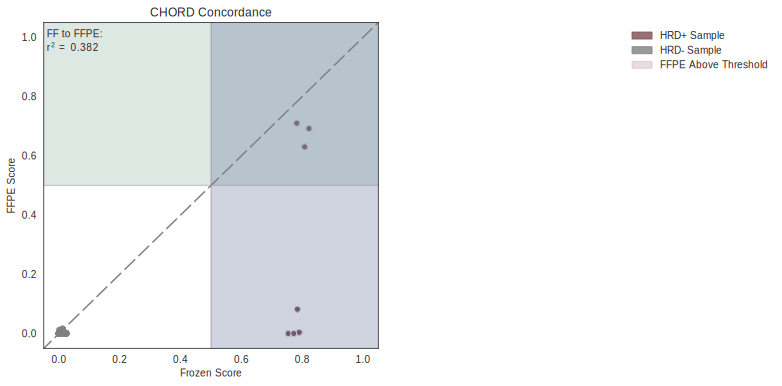

In [30]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(
    data=st8,
    x="Fresh Frozen CHORD",
    y="FFPE CHORD",
    ax=ax,
    color="gray",
    edgecolor=None,
)
sns.scatterplot(
    data=st8[(st8["Fresh Frozen HRDetect"]>.7)|(st8["Fresh Frozen CHORD"]>.5)],
    x="Fresh Frozen CHORD",
    y="FFPE CHORD",
    ax=ax,
    color="#7E4E55",
)

# ax.fill_between([-0.05, 2],0.5,1.5, color='#b68990', alpha=0.3)
# ax.fill_betweenx([-0.05, 2], 0.5, 1.5, color='#b68990', alpha=0.3)
ax.fill_between([-0.05, 2],0.5,1.5, color=pal['FFPE'], alpha=0.3)
ax.fill_betweenx([-0.05, 2], 0.5, 1.5, color=pal['Frozen'], alpha=0.3)

sns.lineplot(
    x=[-1,2],
    y=[-1,2],
    ax=ax,
    color="gray",
)

# Extract the red and black point datasets
points = {}
for iid, row in st8[(st8["Fresh Frozen HRDetect"] > .7) | (st8["Fresh Frozen CHORD"] > .5)].set_index("Individual ID").iterrows():
    points[iid] = (
        row[["Fresh Frozen CHORD", "FFPE CHORD"]].values,
        row[["Fresh Frozen CHORD", "Filtered FFPE CHORD"]].values,
    )

ax.axhline(.5, alpha=0.3, color='#b68990')
ax.axvline(.5, alpha=0.3, color='#b68990')
ax.lines[0].set_linestyle((5, (10, 3)))
ax.set_ylim(-0.05,1.05)
ax.set_xlim(-0.05,1.05)
ax.set_ylabel("FFPE Score")
ax.set_xlabel("Frozen Score")
ax.set_title("CHORD Concordance")
ax.annotate("FF to FFPE:", (-.04, 1))
ax.annotate("r$^2$ = {:.3f}".format(r2_score(
    st8["Fresh Frozen CHORD"],#[(hrd_df["FF HRDetect"]>.7)|(hrd_df["FF CHORD"]>.5)]["FF CHORD"],
    st8["FFPE CHORD"]#[(hrd_df["FF HRDetect"]>.7)|(hrd_df["FF CHORD"]>.5)]["FFPE CHORD"]
)), (-.04, .95))

# Custom legend
legend_labels = ['HRD+ Sample', 'HRD- Sample', "FFPE Above Threshold"]
legend_colors = ['#7E4E55', 'gray']
legend_patches = [
    patches.Patch(color=color, alpha=0.8)
    for color in legend_colors
]
legend_patches.append(patches.Patch(color='#b68990', alpha=0.3))
ax.legend(handles=legend_patches, labels=legend_labels, loc='upper right', bbox_to_anchor=(2.2,1), frameon=False)
display_svg()

## Figure 4

#### 4a.

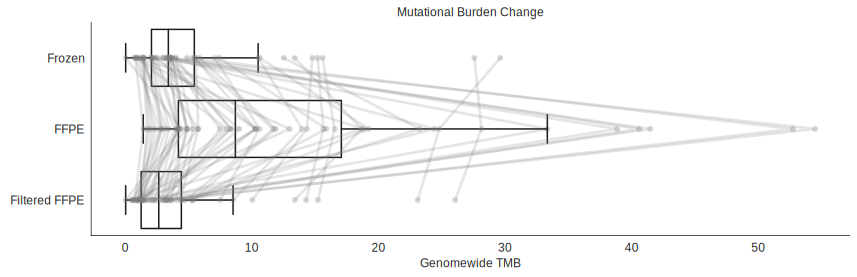

In [31]:
to_plot = pd.melt(
    st13,
    id_vars=["Individual ID"],
    value_vars=["Frozen TMB", "FFPE TMB", "Filtered FFPE TMB"],
    var_name= "TMB Type",
    value_name= "TMB"
)
to_plot["TMB Type"] = to_plot["TMB Type"].str.replace(" TMB","")
fig, ax = plt.subplots(figsize=(12,4))

g_point = sns.pointplot(
    data=to_plot[to_plot.TMB<60],
    y="TMB Type",
    x="TMB",
    hue="Individual ID",
    order=["Frozen","FFPE", "Filtered FFPE", "Dummy"],
    capsize=.075,
    ax=ax,
    legend=False,
    palette=["gray"]*3,
    alpha=0.2,
)

for line in g_point.get_lines():
    line.set_alpha(0.2)

for collection in g_point.collections:
    collection.set_alpha(0.2)
    collection.set_sizes([20])

g_box = sns.boxplot(
    data=to_plot[to_plot.TMB<60],
    y="TMB Type",
    x="TMB",
    order=["Frozen","FFPE", "Filtered FFPE"],
    ax=ax,
    showfliers=False,
    palette=["white"]*3,
    boxprops={"edgecolor":"k"},
    whiskerprops={"color":"k"},
    capprops={"color":"k"},
    medianprops={"color":"k"},
)
ax.legend_.remove()
sns.despine()
ax.set_xlabel("Genomewide TMB")
ax.set_ylabel("")
ax.set_title("Mutational Burden Change", fontsize=12)
# ax.grid(axis="y")
set_all_font_sizes(ax, 12)
display_svg()

#### 4b.

In [32]:
st6

,Individual ID,Tissue Type,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,...,ID9,ID10,ID11,ID12,ID13,ID14,ID15,ID16,ID17,ID18
0,H134753,FF,0.063603,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.104999,0.014534,0.007459,0.004138,0.004828,0.009198,0.0,0.010010,0.000880,0.0
1,H134753,FFPE,0.046795,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000161,0.003018,0.003138,0.002548,0.014100,0.0,0.000000,0.001485,0.0
2,H135022,FF,0.050095,0.057335,0.075328,0.0,0.068346,0.000000,0.000000,0.000000,...,0.036409,0.037039,0.032341,0.016729,0.003743,0.018699,0.0,0.000000,0.000000,0.0
3,H135022,FFPE,0.034954,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.058909,0.049499,0.109094,0.012984,0.073349,0.177441,0.0,0.104315,0.081856,0.0
4,H135387,FF,0.035636,0.038481,0.000000,0.0,0.000000,0.000000,0.033147,0.000000,...,0.156870,0.032498,0.026882,0.010730,0.016382,0.010568,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,H203541,FFPE,0.121930,0.028361,0.000000,0.0,0.176177,0.000000,0.000000,0.050654,...,0.000000,0.004107,0.001646,0.094621,0.004712,0.000029,0.0,0.000000,0.003236,0.0
108,H203542,FF,0.117475,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.003440,0.004588,0.009604,0.000000,0.082011,0.0,0.000000,0.003110,0.0
109,H203542,FFPE,0.087250,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.003862,0.015457,0.024889,0.009353,0.057394,0.0,0.000000,0.005833,0.0
110,H203544,FF,0.095496,0.044517,0.000000,0.0,0.000000,0.047328,0.000000,0.061465,...,0.000000,0.013244,0.001638,0.000000,0.004624,0.007661,0.0,0.000000,0.000000,0.0


In [33]:
contributions = st6.copy().set_index("Individual ID")
bar = pd.DataFrame(columns=["Tissue Type"])
for tissue_type in ["FF", "FFPE"]:
    res = {"Tissue Type":tissue_type}
    for col in contributions[contributions["Tissue Type"]==tissue_type].columns:
        if col == "Tissue Type":
            continue
        if "ID" in col:
            continue
        median_percent = np.median(contributions[contributions["Tissue Type"]==tissue_type][col])
        if median_percent > 0.05:
            res[col] = median_percent

    bar = bar.append(res, ignore_index=True)

# Add Filtered
filtered_contributions = st14.copy().set_index("Individual ID")
res = {"Tissue Type":"Filtered"}
for col in filtered_contributions.columns:
    if col == "Tissue Type":
        continue
    if "ID" in col:
        continue
    median_percent = np.median(filtered_contributions[col])
    if median_percent > 0.05:
        res[col] = median_percent

bar = bar.append(res, ignore_index=True)

bar = bar.set_index("Tissue Type")

# Fill in values where not meeting threshold
for col in bar.columns:
    if np.isnan(bar.loc["FF", col]):
        bar.loc["FF", col] = np.median(contributions[contributions["Tissue Type"]=="FF"][col])
    if np.isnan(bar.loc["FFPE", col]):
        bar.loc["FFPE", col] = np.median(contributions[contributions["Tissue Type"]=="FFPE"][col])
    if np.isnan(bar.loc["Filtered", col]):
        bar.loc["Filtered", col] = np.median(filtered_contributions[col])

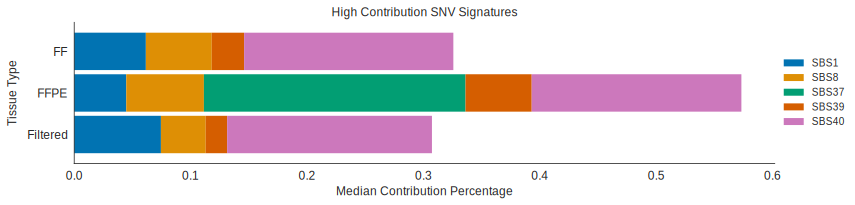

In [34]:
fig, ax = plt.subplots(figsize=(12,3))
g = bar[["SBS1","SBS8","SBS37","SBS39","SBS40"]][::-1].plot(
    kind='barh',stacked=True,ax=ax,width=.9,lw=0,color=sns.color_palette("colorblind")
)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Signatures')
ax.set_title("High Contribution SNV Signatures")
ax.set_xlabel("Median Contribution Percentage")
sns.despine()
format_plot(g)
display_svg()

#### 4c.

In [35]:
contributions = st6.copy().set_index("Individual ID")
bar = pd.DataFrame(columns=["Tissue Type"])
for tissue_type in ["FF", "FFPE"]:
    res = {"Tissue Type":tissue_type}
    for col in contributions[contributions["Tissue Type"]==tissue_type].columns:
        if col == "Tissue Type":
            continue
        if not "ID" in col:
            continue
        median_percent = np.median(contributions[contributions["Tissue Type"]==tissue_type][col])
        if median_percent > 0.025:
            res[col] = median_percent

    bar = bar.append(res, ignore_index=True)

# Add Filtered
filtered_contributions = st14.copy().set_index("Individual ID")
res = {"Tissue Type":"Filtered"}
for col in filtered_contributions.columns:
    if col == "Tissue Type":
        continue
    if not "ID" in col:
        continue
    median_percent = np.median(filtered_contributions[col])
    if median_percent > 0.025:
        res[col] = median_percent

bar = bar.append(res, ignore_index=True)

bar = bar.set_index("Tissue Type")

# Fill in values where not meeting threshold
for col in bar.columns:
    if np.isnan(bar.loc["FF", col]):
        bar.loc["FF", col] = np.median(contributions[contributions["Tissue Type"]=="FF"][col])
    if np.isnan(bar.loc["FFPE", col]):
        bar.loc["FFPE", col] = np.median(contributions[contributions["Tissue Type"]=="FFPE"][col])
    if np.isnan(bar.loc["Filtered", col]):
        bar.loc["Filtered", col] = np.median(filtered_contributions[col])

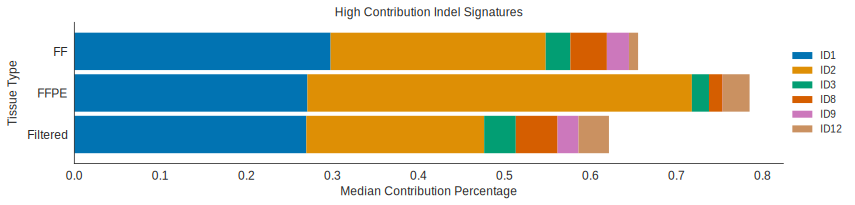

In [36]:
fig, ax = plt.subplots(figsize=(12,3))
g = bar[["ID1","ID2","ID3","ID8","ID9","ID12"]][::-1].plot(
    kind='barh',stacked=True,ax=ax,width=.9,lw=0,color=sns.color_palette("colorblind")
)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Signatures')
ax.set_title("High Contribution Indel Signatures")
ax.set_xlabel("Median Contribution Percentage")
sns.despine()
format_plot(g)
display_svg()

#### 4d.

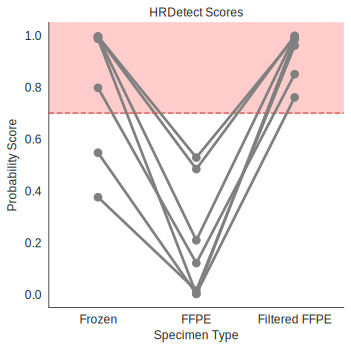

In [37]:
hrd_pos = ["H201537", "H201536", "H203518", "H201539", "H203523", "H201540", "H201538"]
hrd_neg = [col for col in to_plot.columns if not col in hrd_pos]
to_plot = pd.melt(
    st8[st8["Individual ID"].isin(hrd_pos)],
    id_vars=["Individual ID"],
    value_vars=["Fresh Frozen HRDetect", "FFPE HRDetect", "Filtered FFPE HRDetect"],
    var_name= "Specimen Type",
    value_name= "Probability Score"
)
fig, ax = plt.subplots(figsize=(5,5))
g = sns.pointplot(
    data=to_plot.replace(
        {
            "Fresh Frozen HRDetect":"Frozen",
            "FFPE HRDetect":"FFPE",
            "Filtered FFPE HRDetect":"Filtered FFPE",
        }
    ),
    x="Specimen Type",
    y="Probability Score",
    hue = "Individual ID",
    palette=["gray"]*3,
    order=["Frozen","FFPE","Filtered FFPE"],
    capsize=.075,
    ax=ax,
)
ax.legend().remove()
# ax.grid(axis="y")
ax.axhline(.7, color="r", linestyle="--")
prev_x = ax.get_xlim()
ax.fill_between(
    x=[-100,100],
    y1=0.7,
    y2=1.05,
    color='red',
    alpha=0.2,
    linestyle="--"
)
ax.set_xlim(prev_x)
ax.set_ylim(-0.05,1.05)
sns.despine()
ax.set_title("HRDetect Scores")
set_all_font_sizes(ax,12)
display_svg()

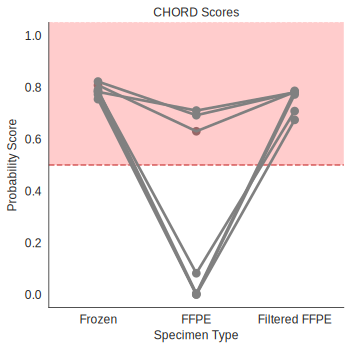

In [38]:
to_plot = pd.melt(
    st8[st8["Individual ID"].isin(hrd_pos)],
    id_vars=["Individual ID"],
    value_vars=["Fresh Frozen CHORD", "FFPE CHORD", "Filtered FFPE CHORD"],
    var_name= "Specimen Type",
    value_name= "Probability Score"
)
fig, ax = plt.subplots(figsize=(5,5))
g = sns.pointplot(
    data=to_plot.replace(
        {
            "Fresh Frozen CHORD":"Frozen",
            "FFPE CHORD":"FFPE",
            "Filtered FFPE CHORD":"Filtered FFPE",
        }
    ),
    x="Specimen Type",
    y="Probability Score",
    hue = "Individual ID",
    palette=["gray"]*3,
    order=["Frozen","FFPE","Filtered FFPE"],
    capsize=.075,
    ax=ax,
)
ax.legend().remove()
# ax.grid(axis="y")
ax.axhline(.5, color="r", linestyle="--")
prev_x = ax.get_xlim()
ax.fill_between(
    x=[-100,100],
    y1=0.5,
    y2=1.05,
    color='red',
    alpha=0.2,
    linestyle="--"
)
ax.set_xlim(prev_x)
ax.set_ylim(-0.05,1.05)

sns.despine()
ax.set_title(f"CHORD Scores")
set_all_font_sizes(ax,12)
display_svg()

## Figure 5

#### 5b.

In [39]:
to_plot = pd.melt(
    st16[[
        "Individual ID",
        "FFPE 96 Context",
        "FFPErase Filtered 96 Context",
        "FFPESig Filtered 96 Context",
        "FFPolish Filtered 96 Context",
        "FFPEimpact Filtered 96 Context"
    ]],
    id_vars=["Individual ID"],
    value_vars=[
        "FFPE 96 Context",
        "FFPErase Filtered 96 Context",
        "FFPESig Filtered 96 Context",
        "FFPolish Filtered 96 Context",
        "FFPEimpact Filtered 96 Context"
    ],
    var_name = "Method",
    value_name = "Cosine Similarity"
).replace(
    {
        "FFPE 96 Context": "Unfiltered FFPE",
        "FFPErase Filtered 96 Context": "FFPErase",
        "FFPESig Filtered 96 Context": "FFPESig",
        "FFPolish Filtered 96 Context": "FFPolish",
        "FFPEimpact Filtered 96 Context": "FFPEimpact"
    }
)

No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Unfiltered FFPE v.s. FFPErase: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.024e-07 U_stat=6.650e+02
Unfiltered FFPE v.s. FFPESig: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.951e-02 U_stat=1.954e+03
Unfiltered FFPE v.s. FFPolish: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.413e+03
Unfiltered FFPE v.s. FFPEimpact: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.494e+03


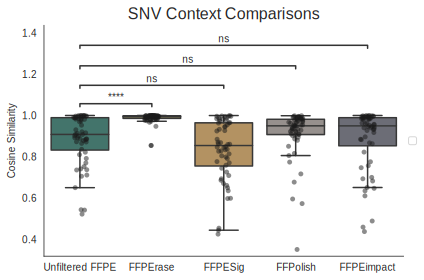

In [40]:
import met_brewer
kandinsky_palette = met_brewer.met_brew(
    name="Kandinsky", n=6, brew_type="continuous"
)
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(
    data=to_plot,
    x="Method",
    y="Cosine Similarity",
    showfliers=False,
    ax=ax,
    palette=kandinsky_palette,
)
sns.stripplot(
    data=to_plot,
    x="Method",
    y="Cosine Similarity",
    ax=ax,
    palette=["k"]*5,
    alpha=0.5,
)

x = "Method"
y = "Cosine Similarity"
box_pairs=[
    (("Unfiltered FFPE"), ("FFPErase")),
    (("Unfiltered FFPE"), ("FFPESig")),
    (("Unfiltered FFPE"), ("FFPolish")),
    (("Unfiltered FFPE"), ("FFPEimpact")),
    ]

add_stat_annotation(ax, data=to_plot, x=x, y=y, box_pairs=box_pairs,
                    test='Mann-Whitney', loc='inside', verbose=2)

ax.legend(loc='center left', bbox_to_anchor=(1,.5))
sns.despine()
ax.set_ylabel("Cosine Similarity", fontsize=10)
ax.set_xlabel("", fontsize=14)
ax.set_title("SNV Context Comparisons", fontsize=16)
display_svg()

#### 5c.

In [41]:
to_plot = pd.melt(
    st16[[
        "Individual ID",
        "FFPE 83 Indel Context",
        "FFPErase Filtered 83 Indel Context",
        "FFPEimpact Filtered 83 Indel Context"
    ]],
    id_vars=["Individual ID"],
    value_vars=[
        "FFPE 83 Indel Context",
        "FFPErase Filtered 83 Indel Context",
        "FFPEimpact Filtered 83 Indel Context"
    ],
    var_name = "Method",
    value_name = "Cosine Similarity"
).replace(
    {
        "FFPE 83 Indel Context": "Unfiltered FFPE",
        "FFPErase Filtered 83 Indel Context": "FFPErase",
        "FFPEimpact Filtered 83 Indel Context": "FFPEimpact"
    }
)

No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Unfiltered FFPE v.s. FFPErase: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.838e-10 U_stat=4.540e+02
Unfiltered FFPE v.s. FFPEimpact: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.560e+03


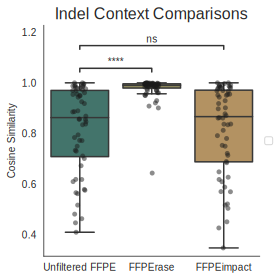

In [42]:
import met_brewer
kandinsky_palette = met_brewer.met_brew(
    name="Kandinsky", n=6, brew_type="continuous"
)
fig, ax = plt.subplots(figsize=(4, 4))
sns.boxplot(
    data=to_plot,
    x="Method",
    y="Cosine Similarity",
    showfliers=False,
    ax=ax,
    palette=kandinsky_palette,
)
sns.stripplot(
    data=to_plot,
    x="Method",
    y="Cosine Similarity",
    ax=ax,
    palette=["k"]*5,
    alpha=.5
)

x = "Method"
y = "Cosine Similarity"
box_pairs=[
    (("Unfiltered FFPE"), ("FFPErase")),
    (("Unfiltered FFPE"), ("FFPEimpact")),
    ]

add_stat_annotation(ax, data=to_plot, x=x, y=y, box_pairs=box_pairs,
                    test='Mann-Whitney', loc='inside', verbose=2)

ax.legend(loc='center left', bbox_to_anchor=(1,.5))
sns.despine()
ax.set_ylabel("Cosine Similarity", fontsize=10)
ax.set_xlabel("", fontsize=14)
ax.set_title("Indel Context Comparisons", fontsize=16)
display_svg()

## Figure 6

#### 6a.

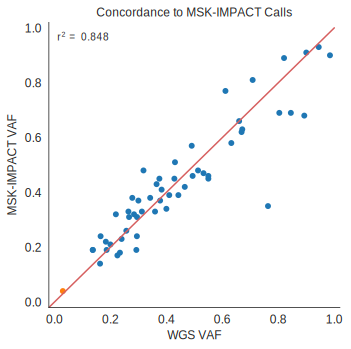

In [43]:
to_plot = st17[st17["Called By"]=="both"].copy()
to_plot["MSK-IMPACT VAF"]=to_plot["MSK-IMPACT VAF"].astype(float).fillna(0)
to_plot["WGS VAF"]=to_plot["WGS VAF"].astype(float).fillna(0)
to_plot["Artifact"] = to_plot["FFPErase Artifact Score"] >= .5
to_plot["FFPErase Artifact Score"]=to_plot["FFPErase Artifact Score"].astype(float)
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(
    data=to_plot,
    x="WGS VAF",
    y="MSK-IMPACT VAF",
    hue="Artifact",
    # palette=[list(pal.values())[-1]],
    legend=False,
    linewidth=0,
    ax=ax
)
sns.lineplot(x=[-1,1], y=[-1,1], color="r", linestyle="--", ax=ax)
ax.set_ylim(-.02,1.02)
ax.set_xlim(-.02,1.02)
ax.set_title(f"Concordance to MSK-IMPACT Calls", fontsize=14)
ax.set_ylabel("MSK-IMPACT VAF", fontsize=14)
ax.set_xlabel("WGS VAF", fontsize=14)
ax.annotate("r$^2$ = {:.3f}".format(r2_score(
    to_plot["WGS VAF"],
    to_plot["MSK-IMPACT VAF"]
)), (.01, .95))
sns.despine()
set_all_font_sizes(ax, 12)
display_svg()